# library import

In [1]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# load csv file

In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/voice_project/train.csv')
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [4]:
train.shape

(400, 2)

In [5]:
train.label.groupby(train.label).count()

label
0    40
1    40
2    40
3    40
4    40
5    40
6    40
7    40
8    40
9    40
Name: label, dtype: int64

In [6]:
X = train.label.groupby(train.label).count().index
Y = train.label.groupby(train.label).count()

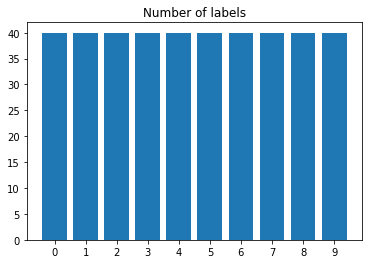

In [7]:
plt.bar(X, Y)
plt.xticks(X)
plt.title("Number of labels")
plt.show()

In [8]:
test = pd.read_csv('/content/gdrive/MyDrive/voice_project/test.csv')
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


# fourier_transform audio

In [9]:
def fourier_transform(num = 0):
    # Audio Sample Directory
    sample = os.listdir('/content/gdrive/MyDrive/voice_project/train/')
    temp = train[train.label == num].file_name
    file_name = temp[temp.index[0]]
    
    file = '/content/gdrive/MyDrive/voice_project/train/train/' + file_name
    # Get Audio from the location
    data,sample_rate = librosa.load(file)

    fft = np.fft.fft(data) 

    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))

    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]

    fig = plt.figure(figsize = (14,5))
    plt.plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title(f"Fourier transform of audio label {num}")
    plt.show()

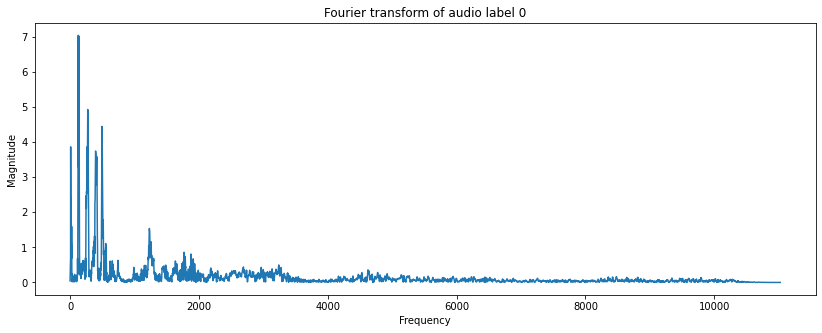

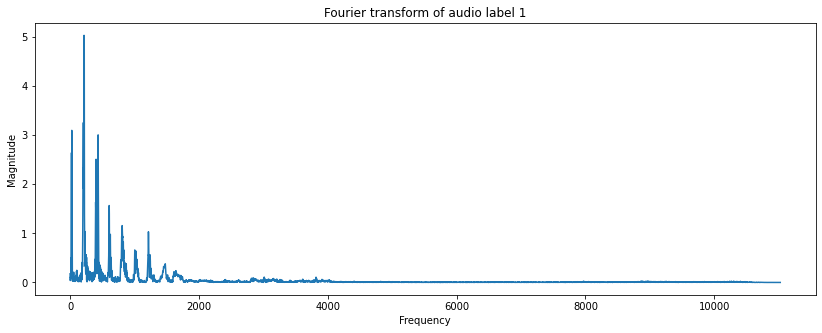

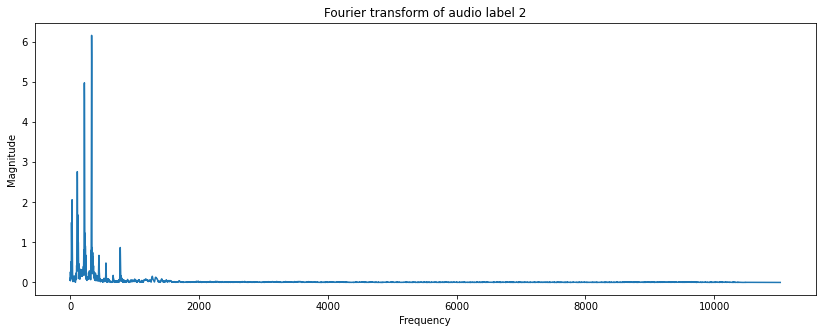

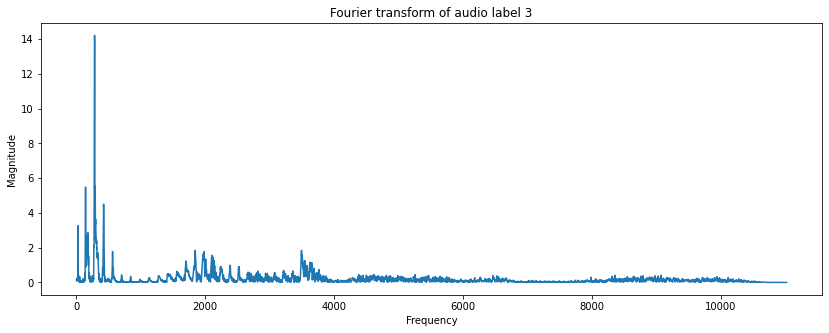

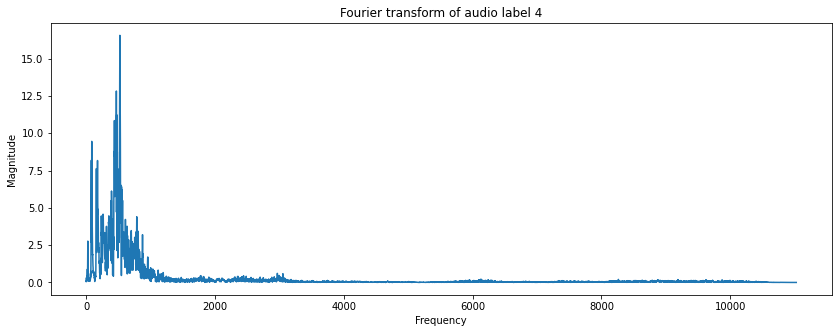

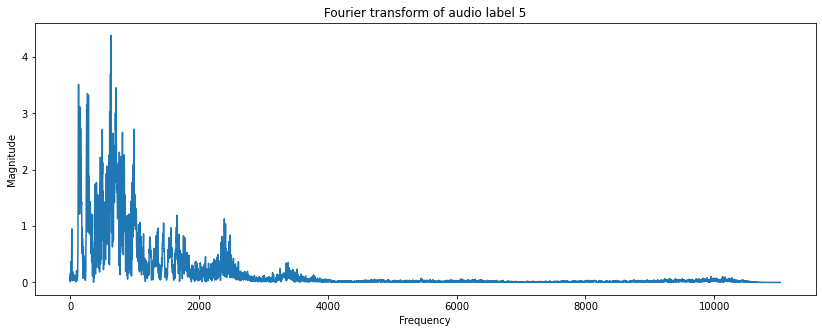

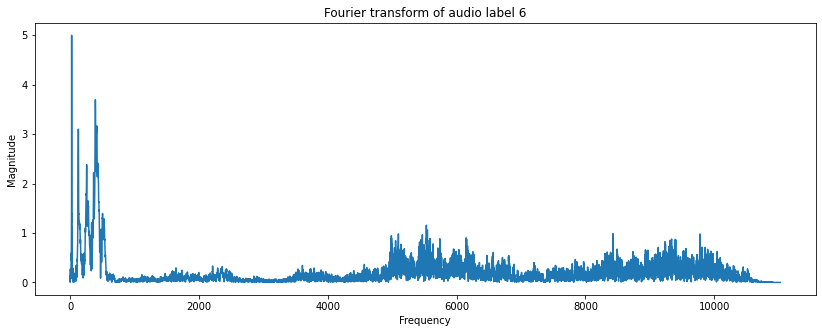

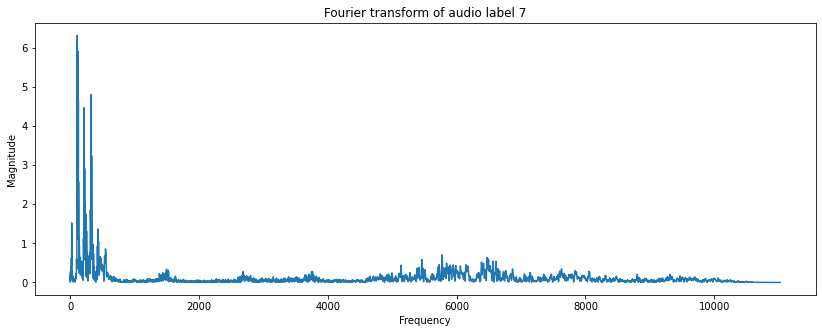

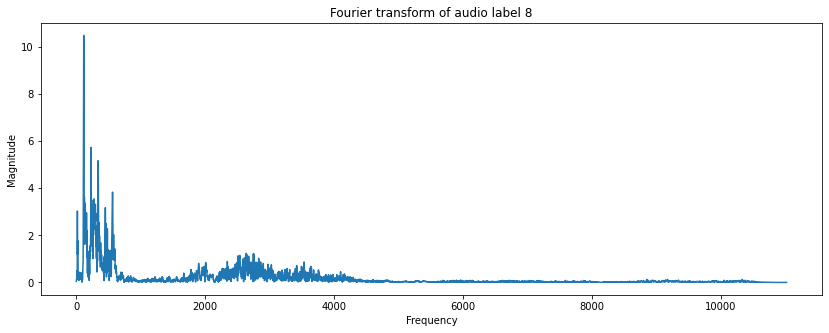

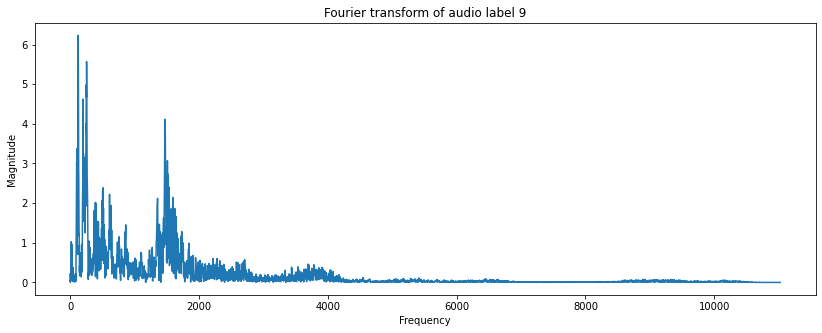

In [10]:
for i in range(0,10):
    fourier_transform(i)

# preparing

In [11]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(929)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  400 non-null    object
 1   label      400 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


# audio -> feature numpy



In [13]:
data, sample_rate = librosa.load('/content/gdrive/MyDrive/voice_project/train/train/001.wav', sr = 16000)
print('sample_rate:', sample_rate, ', audio shape:', data.shape)
print('length:', data.shape[0]/float(sample_rate), 'secs')

sample_rate: 16000 , audio shape: (10192,)
length: 0.637 secs


In [14]:
from tqdm.notebook import tqdm

train_file_names = train["file_name"].to_numpy()
test_file_names = test["file_name"].to_numpy()
target = train["label"].to_numpy()

def load_audio(file_names, target, path):   
  audios = []
  for audio in tqdm(file_names):
    # librosa를 이용하여 데이터 로드
    an_audio, _ = librosa.load(path+audio, sr=sr)
    audio_array = np.array(an_audio)
    audios.append(audio_array)
  audios = np.array(audios)

  targets = target.copy()

  return audios, targets

In [15]:
sr = 16000

In [16]:
audio_train, target_train = load_audio(train_file_names, target, path='/content/gdrive/MyDrive/voice_project/train/train/')
audio_test, _ = load_audio(test_file_names, np.array([None]), path='/content/gdrive/MyDrive/voice_project/test/test/')

  0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


  0%|          | 0/200 [00:00<?, ?it/s]

# Mel & mfcc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


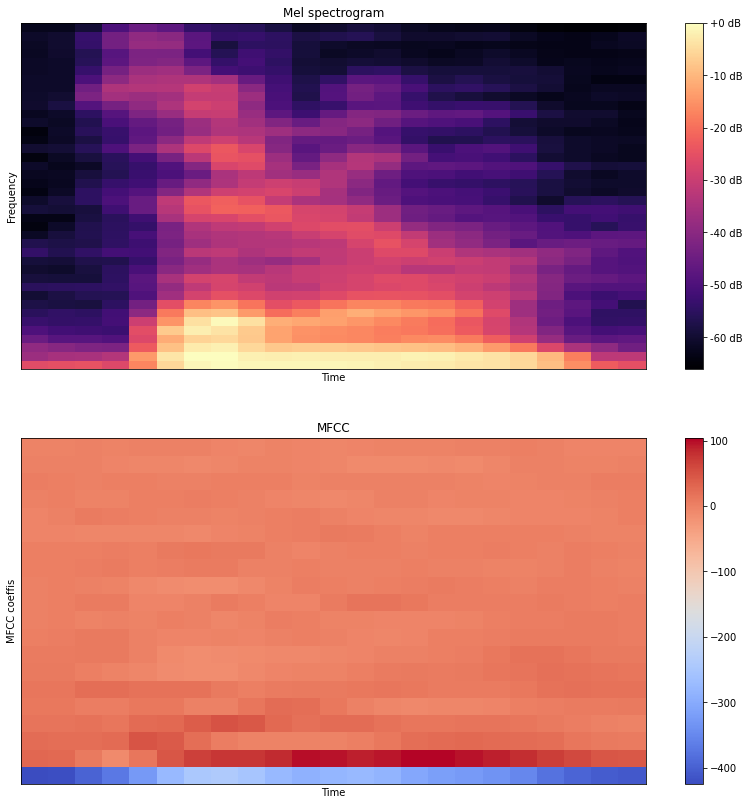

In [17]:
plt.figure(figsize=(14,14))
ax = plt.subplot(2, 1, 1)


ax = plt.subplot(2, 1, 1)
S = librosa.feature.melspectrogram(audio_train[15], sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(audio_train[15], sr=sr, n_mels=40)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC coeffis")
plt.colorbar()

# padding

In [18]:
def random_pad(mels, pad_size, mfcc=True):

  pad_width = pad_size - mels.shape[1]
  rand = np.random.rand()
  left = int(pad_width * rand)
  right = pad_width - left
  
  if mfcc:
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
  else:
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')


  return mels

In [19]:
size = 40
pad_size = 40
repeat_size = 5

In [20]:
audio_mels = []
audio_mfcc = []

for y in audio_train:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
  
  for i in range(repeat_size):
    audio_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    audio_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [21]:
audio_mels_array_test = []
audio_mfcc_array_test = []

for y in audio_test:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

  audio_mels_array_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
  audio_mfcc_array_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [22]:
audio_mels_array = np.array(audio_mels, np.float64)
audio_mfcc_array = np.array(audio_mfcc, np.float64)

audio_mels_array_test = np.array(audio_mels_array_test, np.float64)
audio_mfcc_array_test = np.array(audio_mfcc_array_test, np.float64)

In [23]:
print(audio_mels_array)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.70007217 0.58683872 0.        ]
  [0.         0.         0.         ... 0.68838769 0.50519609 0.        ]
  [0.         0.         0.         ... 0.63519216 0.53287685 0.        ]
  ...
  [0.         0.         0.         ... 0.05880369 0.05487862 0.        ]
  [0.         0.         0.         ... 0.03839018 0.04768655 0.        ]
  [0.         0.         0.         ... 0.00350351 0.         0.        ]]

 [[0.         0.         0.         ... 0.70007217 0.58683872 0.        ]
  [0.         0.      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


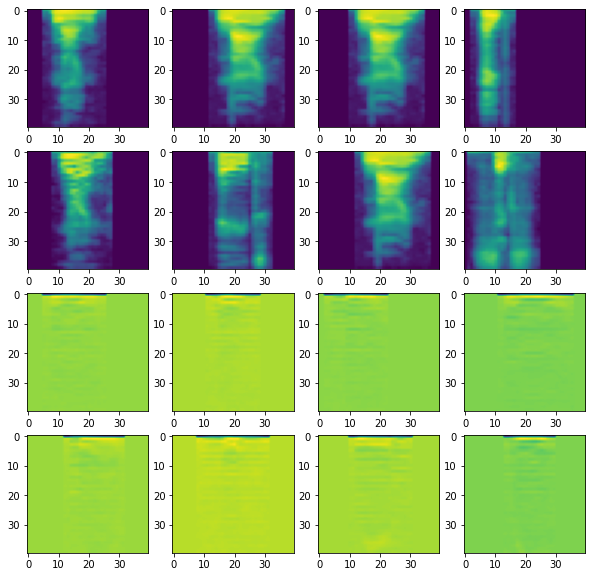

In [24]:
target_num = 2
target_num_idx = np.where(target_train==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')

# Modeling

In [25]:
from sklearn.model_selection import train_test_split

repeated_target = np.repeat(target_train,repeat_size)

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import keras

In [27]:
def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(filters_in, kernel_size=(3, 3), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    shortcut_channel = x.shape.as_list()[0]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [28]:
def build_model():

  inputs = tf.keras.layers.Input(shape=(size,pad_size,1))

  outputs = Conv2D(16,(3,3),activation=None,padding='same',kernel_initializer='he_normal')(inputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = MaxPool2D((2,2))(outputs)

  outputs = residual_block(outputs, 16, 32)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 32, 32)
  # outputs = residual_block(outputs, 32, 32)
  outputs = residual_block(outputs, 32, 64)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 64, 64)
  # outputs = residual_block(outputs, 64, 64)
  # outputs = MaxPool2D((2,2))(outputs)

  outputs = GlobalAveragePooling2D()(outputs)
  # outputs = Flatten()(outputs)

  outputs = Dense(32,activation=None,kernel_initializer='he_normal')(outputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = Dropout(0.5)(outputs)

  outputs = Dense(10,activation='softmax')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# model = build_model()
# model.summary()

# StratifiedKFold

In [29]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

acc_list = []
pred_list = []
skf = StratifiedKFold(n_splits=5)

for fold,(train_index, val_index) in enumerate(skf.split(audio_mels_array, repeated_target)):

  print(f'\n********** {fold+1} fold **********')

  preds_val_list = []
  ### melspectrogram ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mels_array[train_index], audio_mels_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"/content/gdrive/MyDrive/voice_project/model.res_test_0615_mels_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mels_array_test))
  print(f'mels_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### mfcc ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mfcc_array[train_index], audio_mfcc_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"/content/gdrive/MyDrive/voice_project/model.res_test_0615_mfcc_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mfcc_array_test))
  print(f'mfcc_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### ensemble ###
  val_pred_result = preds_val_list[0].copy()
  for i in range(1, len(preds_val_list)):
      val_pred_result += preds_val_list[i]
  val_pred_label = np.argmax(val_pred_result, axis=1)
  en_acc = accuracy_score(y_val,val_pred_label)
  acc_list.append(en_acc)
  print(f'ensemble_model_acc : {en_acc:.4f}')

print(f'\n\nmean_acc : {np.mean(acc_list):.4f}')


********** 1 fold **********
mels_model_acc : 0.9900
mfcc_model_acc : 0.9650
ensemble_model_acc : 0.9900

********** 2 fold **********
mels_model_acc : 0.9550
mfcc_model_acc : 0.9625
ensemble_model_acc : 0.9775

********** 3 fold **********
mels_model_acc : 0.9525
mfcc_model_acc : 0.9325
ensemble_model_acc : 0.9825

********** 4 fold **********
mels_model_acc : 0.9200
mfcc_model_acc : 0.9175
ensemble_model_acc : 0.9725

********** 5 fold **********
mels_model_acc : 0.9375
mfcc_model_acc : 0.9025
ensemble_model_acc : 0.9800


mean_acc : 0.9805


In [30]:
test_pred_result = pred_list[0].copy()
for i in range(1, len(pred_list)):
    test_pred_result += pred_list[i]

submission = pd.read_csv('/content/gdrive/MyDrive/voice_project/sample_submission.csv')
submission['label'] = np.argmax(test_pred_result, axis=1)
submission.head()
submission.to_csv('/content/gdrive/MyDrive/voice_project/submit1.csv', index=False)

# Test


In [34]:
def get_audio(file_name):
    # Audio Sample Directory
    file = '/content/gdrive/MyDrive/voice_project/test/test/' + file_name
    # Get Audio from the location
    data,sample_rate = librosa.load(file)
    
    # Plot the audio wave
    dsp.waveshow(data,sr=sample_rate)
    plt.show()
    
    # Show the widget
    return Audio(data=data,rate=sample_rate)

In [35]:
test_audio = os.listdir('/content/gdrive/MyDrive/voice_project/test/test/')

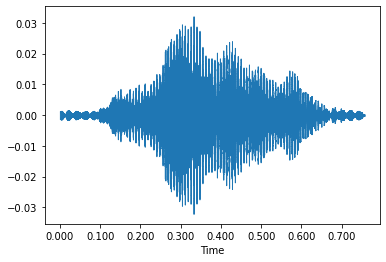

In [46]:
get_audio('042.wav')

In [36]:
for data in test_audio:
 get_audio(data)

Output hidden; open in https://colab.research.google.com to view.